In [3]:
import torch
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import torch
import dgl
import ast
import torch.nn.functional as F

# 1. Make Graph Data
1. Load Data
2. Make Edge Feature
3. Make Node Feature 
    - Embeddings
4. Make Graph
    - train / valid / test masks 

## 1) Load Data 
- Train / Test

In [4]:
train_file_path = './data/train.csv'
df_train = pd.read_csv(train_file_path)

test_file_path = './data/test.csv'
df_test = pd.read_csv(test_file_path)

df_train.head(5)

,id,label,claim,published_date,keybert_keywords,ner_keywords,youtube0,youtube1,youtube2,youtube3,youtube4,youtube5,youtube6,youtube7,youtube8,youtube9
0,0,0,Did a Vermont Woman Post a Joke About Trump Br...,2018-01-25,"['trump', 'vermont', 'woman']","['vermont', 'trump', 'woman']",Citizen Trump A talk given at the University ...,News Donald Trump has a great woman problem N...,Trump Supporters Remain Despite Vulgar Slur J...,BREAKING Donald trump has a great woman proble...,Revolutionary War SNL The Patriots from New E...,World News Donald Trump has a great woman prob...,Latest News Donald Trump has a great woman pro...,AM Executive Session Gender Matters The U S Pr...,Trump Discusses Tax Bill Gives ;Total Support ...,Chicago s Women s March January This is what ...
1,1,1,Were Baseball Players Photographed Kneeling to...,2017-11-08,"['lynchings', 'baseball', 's']","['lynchings', 'baseball', 's']",Tony Shalhoub Still ;Monk ; after all these ye...,Lesson Class differences and racial variation ...,Mass Media Mass Culture and the Golden Age of ...,Mark W Bennett quot;Implicit Bias and the Law ...,Chris Hedges Writing as Resistance presented b...,Race in America FOCIS th Anniversary lecture s...,,,,
2,2,0,Wisconsin state Rep. John Nygren hits pay dirt...,2019-02-07,"['tax', 'wisconsin', 'dirt']","['rep', 'wisconsin', 'tax', 'wisconsin']",Pocan Shutdown Waste of Time Energy Pocan Shu...,Lawmaker This couldn ;t be more embarrassing f...,State Rep Bob Behning Creating teacher career ...,US GOV th,Representative John Macco of the th talks the ...,Democratic Senator Calls On Va Gov To Resign M...,Rep Sean Duffy introduces the Reciprocal Trade...,Rep Dan Caulkins on IL Minimum Wage Hike Stat...,Rep Weber Worried More Jobs Will Leave IL Rea...,Foxconn May Not Build B Wisconsin Plant Presid...
3,3,0,Progressive group accuses Senate splinter grou...,2017-11-04,"['donors', 'cashing', 'senate']","['cashing', 'senate', 'donors']",Roy Moore s Attorney Refers To News Anchor ;s ...,Documents that Changed the Way We Live Docume...,Time to Wake Up EPA Nominees Show Blatant Disr...,Училище по персонализирана медицина Панел Учи...,Conference Theme Panel Economics for a New Pro...,,,,,
4,4,0,Seal with Unusual Stripe Pattern Markings Spot...,2016-10-21,"['seal', 'washington', 'markings']","['seal', 'washington', 'markings']",Parking Lot Striping Garland Texas Asphalt st...,Learn about the MAHLE Original Gasket Line Bi...,Austroads Guide to Road Design Part Session of,I Major Deck and Superstructure Rehabilitation...,The Premier Parking Lot Striping Company in Au...,,,,,


In [5]:
df_train.columns

Index(['id', 'label', 'claim', 'published_date', 'keybert_keywords',
       'ner_keywords', 'youtube0', 'youtube1', 'youtube2', 'youtube3',
       'youtube4', 'youtube5', 'youtube6', 'youtube7', 'youtube8', 'youtube9'],
      dtype='object')

In [6]:
df = pd.concat([df_train, df_test]).reset_index(drop=True)
df

,id,label,claim,published_date,keybert_keywords,ner_keywords,youtube0,youtube1,youtube2,youtube3,youtube4,youtube5,youtube6,youtube7,youtube8,youtube9
0,0,0.0,Did a Vermont Woman Post a Joke About Trump Br...,2018-01-25,"['trump', 'vermont', 'woman']","['vermont', 'trump', 'woman']",Citizen Trump A talk given at the University ...,News Donald Trump has a great woman problem N...,Trump Supporters Remain Despite Vulgar Slur J...,BREAKING Donald trump has a great woman proble...,Revolutionary War SNL The Patriots from New E...,World News Donald Trump has a great woman prob...,Latest News Donald Trump has a great woman pro...,AM Executive Session Gender Matters The U S Pr...,Trump Discusses Tax Bill Gives ;Total Support ...,Chicago s Women s March January This is what ...
1,1,1.0,Were Baseball Players Photographed Kneeling to...,2017-11-08,"['lynchings', 'baseball', 's']","['lynchings', 'baseball', 's']",Tony Shalhoub Still ;Monk ; after all these ye...,Lesson Class differences and racial variation ...,Mass Media Mass Culture and the Golden Age of ...,Mark W Bennett quot;Implicit Bias and the Law ...,Chris Hedges Writing as Resistance presented b...,Race in America FOCIS th Anniversary lecture s...,,,,
2,2,0.0,Wisconsin state Rep. John Nygren hits pay dirt...,2019-02-07,"['tax', 'wisconsin', 'dirt']","['rep', 'wisconsin', 'tax', 'wisconsin']",Pocan Shutdown Waste of Time Energy Pocan Shu...,Lawmaker This couldn ;t be more embarrassing f...,State Rep Bob Behning Creating teacher career ...,US GOV th,Representative John Macco of the th talks the ...,Democratic Senator Calls On Va Gov To Resign M...,Rep Sean Duffy introduces the Reciprocal Trade...,Rep Dan Caulkins on IL Minimum Wage Hike Stat...,Rep Weber Worried More Jobs Will Leave IL Rea...,Foxconn May Not Build B Wisconsin Plant Presid...
3,3,0.0,Progressive group accuses Senate splinter grou...,2017-11-04,"['donors', 'cashing', 'senate']","['cashing', 'senate', 'donors']",Roy Moore s Attorney Refers To News Anchor ;s ...,Documents that Changed the Way We Live Docume...,Time to Wake Up EPA Nominees Show Blatant Disr...,Училище по персонализирана медицина Панел Учи...,Conference Theme Panel Economics for a New Pro...,,,,,
4,4,0.0,Seal with Unusual Stripe Pattern Markings Spot...,2016-10-21,"['seal', 'washington', 'markings']","['seal', 'washington', 'markings']",Parking Lot Striping Garland Texas Asphalt st...,Learn about the MAHLE Original Gasket Line Bi...,Austroads Guide to Road Design Part Session of,I Major Deck and Superstructure Rehabilitation...,The Premier Parking Lot Striping Company in Au...,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7128,1851,NaN,COMMENTARY: COVID-19 Diary Day 6: Clinicians' ...,2020-04-10,"['clinicians', 'diary']","['clinicians', 'diary']",Adding Services and Products,Adding Clinicians,Acting Director ;s Message April,Adding and Editing Account Users,Advice for New Therapists Subscribe now for m...,COVID Clinical Webinar,Diary of a Researcher Day April Libby Researc...,THE HARDEST SURGERY OPERATION I ;VE EVER EXPER...,Configuring Business Basics,Quick Navigational Tips
7129,1852,NaN,Facebook and Instagram posts shared thousands ...,2020-05-25,"['instagram', 'facebook', 'vaccines']","['instagram', 'facebook', 'vaccines']",Ousted vaccine chief testifies Americans deser...,Anti Vaxxers Could Pose Public Health Risk Whe...,Hope in Thailand for a ;cheaper ; coronavirus ...,Coronavirus crisis These four COVID vaccines a...,How Our Lifestyle is Going To Be Transformed A...,How do vaccines work and what are their variou...,CEO Pascal Soriot on COVID vaccine CNN AstraZ...,The Market for Emergency Vaccines Is Like No O...,CR FOR VACCINE DEVELOPMENT STATUS OF ALL VACCI...,Trials show progress on Covid immunity vaccine...
7130,1853,NaN,Could an antiparasitic drug kill off SARS-CoV-...,2020-04-21,"['antiparasitic', 'drug', 'kill']","['sars', 'antiparasitic', 'drug']",Truth about the corona curing drug Ivermectin ...,Zinc Ascorbic Aci

## 2) Edge Feature

In [7]:
def func(obj):
    List = []
    for word in ast.literal_eval(obj):
        List.append(word)
    return List

In [8]:
df['keybert_keywords']=df['keybert_keywords'].apply(func)
df['ner_keywords']=df['ner_keywords'].apply(func)

In [9]:
# adjacency matrix 구축 -> keybert_keywords 공유하고 있는 claim끼리 연결 

# df['published_date'] = pd.to_datetime(df['published_date'], format='%Y-%m-%d', errors='raise') 
dic_array = np.zeros((len(df),len(df)))
print(dic_array.shape)
print(dic_array.sum())

(7133, 7133)
0.0


In [10]:
src=[]
trg=[]


for i, (i_claim, i_m) in enumerate(zip(df.claim, df.ner_keywords)):
  for j, (j_claim, j_m) in enumerate(zip(df.claim, df.ner_keywords)):

    weight = len(set(i_m).intersection(j_m))
    # print(weight)
    # dic_array[i][j] = 1 # 필요없다면
    if weight > 1 :
      dic_array[i][j] = weight # if edge weight를 적용해보고 싶다면 frequency 활용해볼 수도 
      src.append(i)
      trg.append(j)


print(dic_array.shape)
print(dic_array.sum())

(7133, 7133)
304499.0


In [11]:
dic_array

array([[3., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 3., 0., 0.],
       [0., 0., 0., ..., 0., 3., 0.],
       [0., 0., 0., ..., 0., 0., 4.]])

In [12]:
len(trg)

147470

In [13]:
i_m,j_m

(['south sudan', 'covid', 'sudan', 'son'],
 ['south sudan', 'covid', 'sudan', 'son'])

In [14]:
dic_array

array([[3., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 3., 0., 0.],
       [0., 0., 0., ..., 0., 3., 0.],
       [0., 0., 0., ..., 0., 0., 4.]])

In [15]:
d={
    "src" : src,
    "trg":trg,
    "weight":weight
}
edges_data=pd.DataFrame(data=d,columns=['src','trg','weight'])
edges_data

,src,trg,weight
0,0,0,4
1,0,1495,4
2,0,3326,4
3,1,1,4
4,2,2,4
...,...,...,...
147465,7131,7075,4
147466,7131,7131,4
147467,7132,6566,4
147468,7132,7101,4


In [16]:
# edges_data.to_csv('./data/edges_data_keybert.csv',index=False)

In [17]:
# edges_data=pd.read_csv('./data/edges_data_keybert.csv')
# edges_data

## 3) Node Feature

In [18]:
corpus = df['claim'].tolist()
len(corpus),corpus

(7133,
 ['Did a Vermont Woman Post a Joke About Trump Bringing Back Slavery ?',
  'Were Baseball Players Photographed Kneeling to Protest Lynchings in the 1950s?',
  'Wisconsin state Rep. John Nygren hits pay dirt with property tax claim',
  'Progressive group accuses Senate splinter group of cashing in with donors',
  'Seal with Unusual Stripe Pattern Markings Spotted in Washington',
  'Donald Trump Protester Speaks Out I Was Paid 3,500 to Protest Trump s Rally',
  'Are Thieves Stealing License Plates in a Carjacking Scheme?',
  'Did MSNBC Reporter Say I Hope Coronavirus Kills People and Hurts Trump s Reelection ? This false rumor demonstrates how one subtle video edit can achieve a huge deception.',
  'Rep. Tom Cole: Half of Oklahoma homes have a gun',
  'A claim has circulated on social media that a new virus named hantavirus has emerged in China in March 2020. The posts were viewed hundreds of thousands of times as the world battled the spread of the novel coronavirus, which causes

In [19]:

from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer('all-mpnet-base-v2')
corpus_embeddings = embedder.encode(corpus)


In [20]:
corpus_embeddings.shape, corpus_embeddings

((7133, 768),
 array([[-0.00188012,  0.09448598,  0.01552716, ..., -0.0174304 ,
          0.01390029,  0.00242343],
        [-0.06093101,  0.00677123, -0.00349898, ...,  0.019279  ,
         -0.01516403,  0.02067783],
        [-0.01442548,  0.11008074,  0.04376478, ..., -0.01964711,
         -0.02274496,  0.00216783],
        ...,
        [-0.00351651,  0.0080526 , -0.00564455, ...,  0.00545681,
         -0.04232048, -0.03956319],
        [-0.02291274,  0.0117445 ,  0.00212293, ..., -0.02146702,
         -0.00766304, -0.02736829],
        [ 0.04945886, -0.07820719, -0.00963364, ..., -0.04035792,
         -0.04227081, -0.00939088]], dtype=float32))

In [21]:
df['embedding']=corpus_embeddings.tolist()

In [22]:
df['embedding']

0       [-0.0018801151309162378, 0.09448597580194473, ...
1       [-0.0609310083091259, 0.0067712306044995785, -...
2       [-0.014425477012991905, 0.11008074134588242, 0...
3       [-0.014716089703142643, 0.11111533641815186, 0...
4       [0.008681867271661758, 0.03266747295856476, -0...
                              ...                        
7128    [0.015135074965655804, 0.0831441655755043, 0.0...
7129    [0.0583503320813179, 0.06694129854440689, 0.03...
7130    [-0.003516511293128133, 0.008052599616348743, ...
7131    [-0.022912736982107162, 0.011744500137865543, ...
7132    [0.049458861351013184, -0.07820718735456467, -...
Name: embedding, Length: 7133, dtype: object

## 4) Make Graph

In [23]:
node_features = torch.from_numpy(corpus_embeddings)
node_labels = torch.from_numpy(df['label'].astype('category').cat.codes.to_numpy()).type(torch.LongTensor)
edge_features = torch.from_numpy(edges_data['weight'].to_numpy())
edges_src = torch.from_numpy(edges_data['src'].to_numpy())
edges_dst = torch.from_numpy(edges_data['trg'].to_numpy())

graph = dgl.graph((edges_src, edges_dst), num_nodes=df.shape[0])

graph.ndata['feat'] = node_features
graph.ndata['label'] = node_labels
graph.edata['weight'] = edge_features
graph = dgl.add_self_loop(graph)

/tmp/ipykernel_1413363/1418999816.py:2: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
  node_labels = torch.from_numpy(df['label'].astype('category').cat.codes.to_numpy()).type(torch.LongTensor)


In [24]:
nx_g = dgl.to_networkx(graph)

In [25]:
import networkx as nx
from matplotlib import pyplot, patches

def draw_adjacency_matrix(G, node_order=None, partitions=[], colors=[]):
    """
    - G is a netorkx graph
    - node_order (optional) is a list of nodes, where each node in G
          appears exactly once
    - partitions is a list of node lists, where each node in G appears
          in exactly one node list
    - colors is a list of strings indicating what color each
          partition should be
    If partitions is specified, the same number of colors needs to be
    specified.
    """
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=np.bool, nodelist=node_order)

    #Plot adjacency matrix in toned-down black and white
    fig = pyplot.figure(figsize=(5, 5)) # in inches
    pyplot.imshow(adjacency_matrix,
                  cmap="Greys",
                  interpolation="none")
    
    # The rest is just if you have sorted nodes by a partition and want to
    # highlight the module boundaries
    assert len(partitions) == len(colors)
    ax = pyplot.gca()
    for partition, color in zip(partitions, colors):
        current_idx = 0
        for module in partition:
            ax.add_patch(patches.Rectangle((current_idx, current_idx),
                                          len(module), # Width
                                          len(module), # Height
                                          facecolor="none",
                                          edgecolor=color,
                                          linewidth="1"))
            current_idx += len(module)

/tmp/ipykernel_1413363/1343770704.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adjacency_matrix = nx.to_numpy_matrix(G, dtype=np.bool, nodelist=node_order)


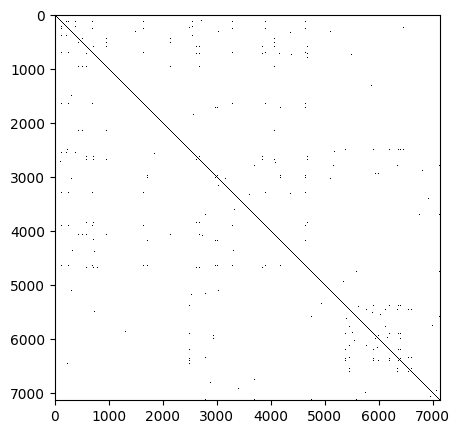

In [26]:
draw_adjacency_matrix(nx_g)

In [27]:
node_labels

tensor([ 0,  1,  0,  ..., -1, -1, -1])

In [28]:
with open('./data/train_mask.txt','r+') as f:
    train_idx=list(ast.literal_eval(f.readline()))
    
with open('./data/val_mask.txt','r+') as f:
    val_idx=list(ast.literal_eval(f.readline()))

In [29]:
n_nodes=df.shape[0]
train_n_nodes = df_train.shape[0]
dataset_indices = list(range(train_n_nodes))

np.random.shuffle(dataset_indices)
num_train = int(train_n_nodes * 0.8)
num_val = int(train_n_nodes*0.2)
# train_idx, val_idx = dataset_indices[:num_train], dataset_indices[num_train:]


train_mask = torch.zeros(n_nodes, dtype=torch.bool)
val_mask = torch.zeros(n_nodes, dtype=torch.bool)
test_mask = torch.zeros(n_nodes, dtype=torch.bool)

In [30]:
# with open('./data/train_mask.txt','w+') as f:
#     f.write(','.join(map(str,train_idx)))
# with open('./data/val_mask.txt','w+') as f:
#     f.write(','.join(map(str, val_idx)))

In [31]:
train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[num_train + num_val+1:] = True

In [65]:
len(test_mask[test_mask==True])

1856

# 2. Define Model

In [66]:
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F

# Graph Neural Network with Attention Layers where the node features are concatenated for attention    
class GAT(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_heads, n_classes):
        super(GAT, self).__init__()
        self.hid_dim = hidden_dim
        self.gat1 = dglnn.GATConv(in_dim, hidden_dim, num_heads)
        self.gat2 = dglnn.GATConv(hidden_dim*num_heads, n_classes, 1)
#         self.avgpooling = dglnn.AvgPooling()
#         self.drop = nn.Dropout(p = 0.3)
# #         self.maxpooling = MaxPooling()
#         self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g, h):
        # Apply graph convolution and activation.
        bs = h.shape[0]
        h = F.relu(self.gat1(g, h))
        h = h.reshape(bs, -1)
        h = F.relu(self.gat2(g, h))
        h = h.reshape(bs, -1)
        # h = self.drop(h)
        # h = self.avgpooling(g, h)
#         hmax = self.maxpooling(g, h)
#         h = torch.cat([havg, hmax], 1)
        
        return h # self.classify(h)

In [83]:
# Create the model with given dimensions
model = GAT(graph.ndata['feat'].shape[1], 16, 3, 2)
model

GAT(
  (gat1): GATConv(
    (fc): Linear(in_features=768, out_features=48, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (gat2): GATConv(
    (fc): Linear(in_features=48, out_features=2, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
)

In [84]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
epochs = 300  

# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 0.95 ** epoch,
#                                         last_epoch=-1,
#                                         verbose=False)

In [85]:
n_features = node_features.shape[1]
n_labels = 2

In [86]:
logits = model(graph, node_features)
logits

tensor([[0.0378, 0.0000],
        [0.0131, 0.0000],
        [0.0007, 0.0000],
        ...,
        [0.0088, 0.0000],
        [0.0411, 0.0000],
        [0.0633, 0.0000]], grad_fn=<ReshapeAliasBackward0>)

In [87]:
logits[train_mask], node_labels[train_mask]

(tensor([[0.0378, 0.0000],
         [0.0131, 0.0000],
         [0.0007, 0.0000],
         ...,
         [0.0614, 0.0000],
         [0.1553, 0.0000],
         [0.0000, 0.0000]], grad_fn=<IndexBackward0>),
 tensor([0, 1, 0,  ..., 0, 1, 1]))

In [88]:
def evaluate(model, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [89]:
for epoch in range(epochs):
    model.train()
    # forward propagation by using all nodes
    logits = model(graph, node_features)
    # compute loss
    loss = F.cross_entropy(logits[train_mask], node_labels[train_mask])
    # compute validation accuracy
    acc = evaluate(model, graph, node_features, node_labels, val_mask)
    # backward propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(acc)

0.47821969696969696
0.48200757575757575
0.48579545454545453
0.4952651515151515
0.4981060606060606
0.5075757575757576
0.5132575757575758
0.5160984848484849
0.521780303030303
0.5236742424242424
0.5303030303030303
0.5445075757575758
0.5700757575757576
0.5785984848484849
0.5918560606060606
0.6145833333333334
0.6221590909090909
0.65625
0.6723484848484849
0.678030303030303
0.6875
0.6979166666666666
0.7054924242424242
0.7111742424242424
0.7111742424242424
0.7130681818181818
0.7149621212121212
0.7159090909090909
0.7178030303030303
0.7159090909090909
0.7159090909090909
0.7159090909090909
0.7159090909090909
0.7168560606060606
0.7196969696969697
0.7206439393939394
0.7263257575757576
0.7253787878787878
0.7225378787878788
0.7215909090909091
0.7206439393939394
0.7206439393939394
0.7234848484848485
0.7206439393939394
0.7215909090909091
0.71875
0.7206439393939394
0.7215909090909091
0.7215909090909091
0.7225378787878788
0.7244318181818182
0.7234848484848485
0.7215909090909091
0.7206439393939394
0.72064

In [74]:
model.eval()
with torch.no_grad():
    logits = model(graph, node_features)
    logits = logits[test_mask]
    _, indices = torch.max(logits, dim=1)

In [75]:
pd.DataFrame(indices.numpy(),columns=['label']).to_csv('./answer/221122_3_answer.csv')